# Example analysis of `mtcars` dataset

Load the packages:

In [1]:
library(tidyverse)
library(repr)

options(
    repr.plot.width = 12,
    repr.plot.height = 6
)

── Attaching packages ──────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Some functions:

In [2]:
# Generate a sequence along values of `x` of length `n`
along <- function(x, n = 100) {
    seq(
        from = min(x),
        to = max(x),
        length.out = n
    )
}

# Custom predict()
my_predict <- function(model, newdata, name = "predicted", ...) {
    nd <- tibble(!!name := predict(model, newdata, type = "response", ...))
    dplyr::bind_cols(newdata, nd)
}


## Opis statystyczny

In [3]:
data(mtcars)

In [4]:
summary(mtcars)

      mpg             cyl             disp             hp       
 Min.   :10.40   Min.   :4.000   Min.   : 71.1   Min.   : 52.0  
 1st Qu.:15.43   1st Qu.:4.000   1st Qu.:120.8   1st Qu.: 96.5  
 Median :19.20   Median :6.000   Median :196.3   Median :123.0  
 Mean   :20.09   Mean   :6.188   Mean   :230.7   Mean   :146.7  
 3rd Qu.:22.80   3rd Qu.:8.000   3rd Qu.:326.0   3rd Qu.:180.0  
 Max.   :33.90   Max.   :8.000   Max.   :472.0   Max.   :335.0  
      drat             wt             qsec             vs        
 Min.   :2.760   Min.   :1.513   Min.   :14.50   Min.   :0.0000  
 1st Qu.:3.080   1st Qu.:2.581   1st Qu.:16.89   1st Qu.:0.0000  
 Median :3.695   Median :3.325   Median :17.71   Median :0.0000  
 Mean   :3.597   Mean   :3.217   Mean   :17.85   Mean   :0.4375  
 3rd Qu.:3.920   3rd Qu.:3.610   3rd Qu.:18.90   3rd Qu.:1.0000  
 Max.   :4.930   Max.   :5.424   Max.   :22.90   Max.   :1.0000  
       am              gear            carb      
 Min.   :0.0000   Min.   :3.000  

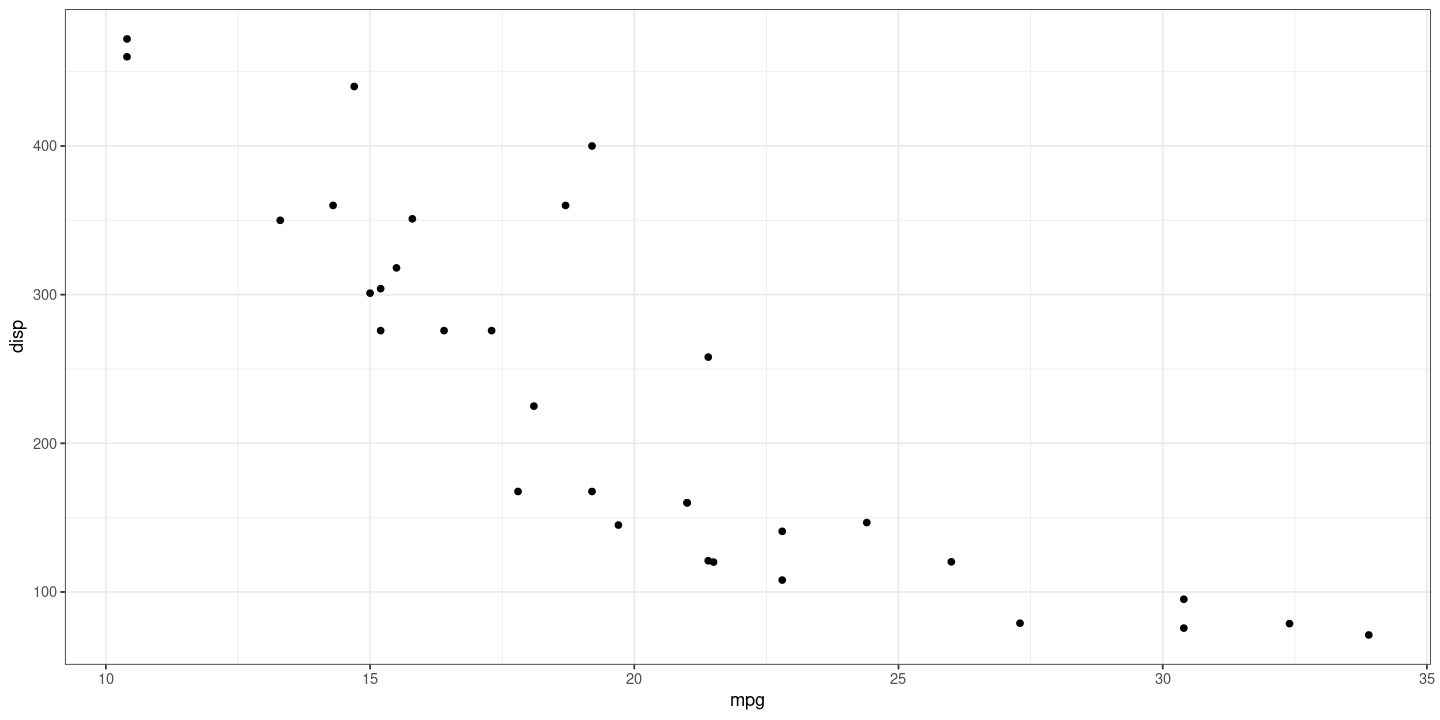

In [5]:
mtcars |>
  ggplot(aes(x=mpg, y=disp)) +
  geom_point() +
  theme_bw()

## Modele

In [10]:
models <- list(
    model_liniowy = ~ lm(mpg ~ disp, data = mtcars),
    model_kwadratowy = ~ lm(mpg ~ I(disp^2) + disp, data = mtcars),
    model_wykładniczy = ~ glm(mpg ~ disp, family = gaussian('log'), data = mtcars),
    model_ze_splajnem = ~ mgcv::gam(mpg ~ s(disp, k = 3), data = mtcars)
) |>
  enframe(name = "model_name", value="model_formula") |>
  mutate(
      model = map(model_formula, ~ eval(.x[[2]])),
      summary = map(model, summary)
  )

models |>
  pull(summary)
  

[[1]]

Call:
lm(formula = mpg ~ disp, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8922 -2.2022 -0.9631  1.6272  7.2305 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.599855   1.229720  24.070  < 2e-16 ***
disp        -0.041215   0.004712  -8.747 9.38e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.251 on 30 degrees of freedom
Multiple R-squared:  0.7183,	Adjusted R-squared:  0.709 
F-statistic: 76.51 on 1 and 30 DF,  p-value: 9.38e-10


[[2]]

Call:
lm(formula = mpg ~ I(disp^2) + disp, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9112 -1.5269 -0.3124  1.3489  5.3946 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.583e+01  2.209e+00  16.221 4.39e-16 ***
I(disp^2)    1.255e-04  3.891e-05   3.226   0.0031 ** 
disp        -1.053e-01  2.028e-02  -5.192 1.49e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘

## Wartości przewidywane

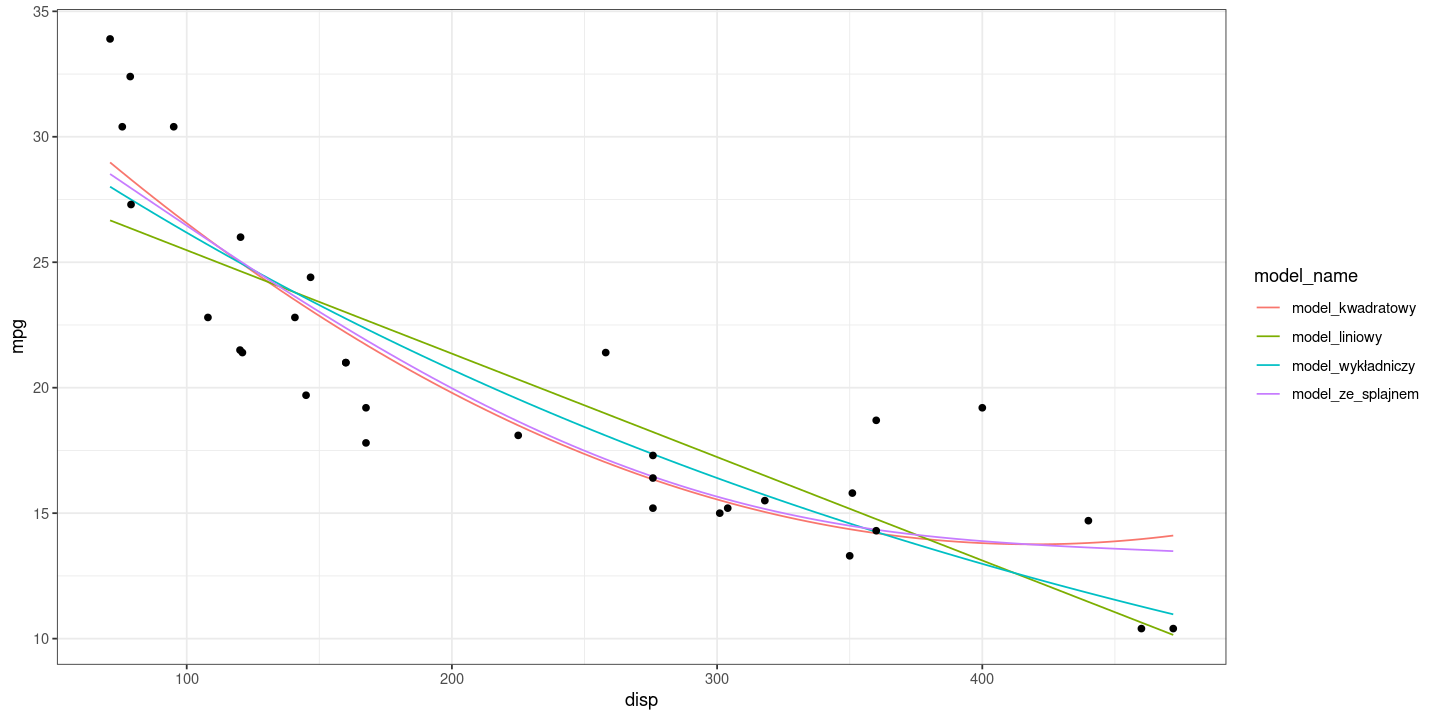

In [11]:
nd <- tibble(disp = along(mtcars$disp))
models |>
  transmute(
      model_name,
      p = purrr::map(model, ~ my_predict(.x, nd))
  ) |>
  unnest(p) |>
  ggplot(aes(x=disp)) +
    geom_line(aes(y=predicted, color = model_name)) +
    geom_point(aes(y=mpg), color = "black", data = mtcars) +
    ylab("mpg") +
    theme_bw()

# Save to CSV

In [1]:
readr::write_csv(mtcars, "mtcars.csv")